In [ ]:
# mongo db 에서 데이터 가져와서 학습

In [1]:
from pymongo import MongoClient
import json

with open("../letter-preprocess/secrets.json", 'r') as f:
    info = json.load(f)

mongo_host = "mongodb://{}:{}@{}:{}".format(info['mongo_info']['user'],
                                                    info['mongo_info']['password'],
                                                    info['host'],
                                                    info['mongo_info']['port'])

mongo = MongoClient(mongo_host)

In [2]:
db = mongo['letter_db']
posts = db.posts

In [3]:
posts.count_documents({})

29957

In [4]:
posts.find_one()

{'_id': ObjectId('608ccc6267a93c593d5b6c2f'),
 'target': 1,
 'content': '1. 객체지향프로그래밍\nA+,프로그래밍 수업을 들으면서 프로그램을 만들고 수정하는 과정이 어릴 때부터 좋아하던 수학문제를 푸는 과정과 비슷하다는 것을 깨달으면서 WEP/APP개발에 관심을 갖게 되었습니다. '}

In [5]:
posts.count_documents({})

29957

In [6]:
posts.find_one({"_id":29956})

In [7]:
import pandas as pd

In [8]:
data = []

for post in posts.find():
    data.append([post['content'], post['target']])
    
df = pd.DataFrame(data, columns=['content', 'target'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29957 entries, 0 to 29956
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  29957 non-null  object
 1   target   29957 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.2+ KB


In [9]:
df.head()

,content,target
0,"1. 객체지향프로그래밍\nA+,프로그래밍 수업을 들으면서 프로그램을 만들고 수정하는...",1
1,"한국oo협회가 운영하는 빅 데이터 관리자과정을 수강하여 Java, 오라클, 하둡, ...",1
2,"NHN엔터테이먼트는 생활, 문화 기반의 IT서비스를 제공하는 기업이기 때문에 많은 ...",1
3,"당시 가장 큰 문제는 12명으로 이뤄진 팀원들 간의 의사소통 문제였습니다. 학과, ...",1
4,[고객의 마음을 움직이는 밝고 친절한 미소]\n제 꿈은 내가 사랑하는 ‘사람들’과 ...,1


In [10]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df['content'], df['target'], 
                                                    test_size=0.2, random_state=121)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(train_x))

In [11]:
print("index_word :" , len(tokenizer.index_word ))  # index - word dict
print("word_index :" , len(tokenizer.word_index ))  # word - index dict
print("단어 출현 빈도수 : " , len(tokenizer.index_docs ))
print("문장 수 : " , tokenizer.document_count)

index_word : 44393
word_index : 44393
단어 출현 빈도수 :  44393
문장 수 :  23965


In [ ]:
# split content to line
words = df['content'].map(lambda x: x.splitlines())

In [ ]:
words.head()

In [ ]:
words.loc[0]

In [ ]:
# split lines to word
def function(row):
    ret = []
    for r in row:
        ret.extend(r.split())
        
    return ret

words = words.map(function)

In [ ]:
words.loc[0]

In [ ]:
words.map(len).plot(kind='bar')

In [ ]:
words.map(len).describe()

In [12]:
# 원-핫 이진 벡터 표현
one_hot_train_x = tokenizer.texts_to_matrix(train_x, mode='binary')
one_hot_test_x = tokenizer.texts_to_matrix(test_x, mode='binary')

In [13]:
one_hot_train_x[0]

array([0., 0., 1., ..., 0., 0., 0.])

In [14]:
one_hot_train_x.shape

(23965, 10000)

In [15]:
len(one_hot_train_x), len(one_hot_test_x)

(23965, 5992)

In [16]:
one_hot_train_x

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [18]:
from keras.utils.np_utils import to_categorical

one_hot_train_y = to_categorical(train_y)
one_hot_test_y = to_categorical(test_y)

In [19]:
one_hot_train_y

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [21]:
# validate
x_val = one_hot_train_x[:1000]
partial_x_train = one_hot_train_x[1000:]

y_val = one_hot_train_y[:1000]
partial_y_train = one_hot_train_y[1000:]

In [22]:
# modeling
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

# compile
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# train
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Epoch 1/20
45/45 [==============================] - 1s 17ms/step - loss: 0.4278 - accuracy: 0.7838 - val_loss: 0.0822 - val_accuracy: 0.9850
Epoch 2/20
45/45 [==============================] - 1s 14ms/step - loss: 0.0357 - accuracy: 0.9936 - val_loss: 0.0512 - val_accuracy: 0.9940
Epoch 3/20
45/45 [==============================] - 1s 15ms/step - loss: 0.0087 - accuracy: 0.9978 - val_loss: 0.0584 - val_accuracy: 0.9930
Epoch 4/20
45/45 [==============================] - 1s 17ms/step - loss: 0.0064 - accuracy: 0.9973 - val_loss: 0.0718 - val_accuracy: 0.9940
Epoch 5/20
45/45 [==============================] - 1s 15ms/step - loss: 0.0047 - accuracy: 0.9982 - val_loss: 0.0744 - val_accuracy: 0.9920
Epoch 6/20
45/45 [==============================] - 1s 14ms/step - loss: 0.0048 - accuracy: 0.9977 - val_loss: 0.0809 - val_accuracy: 0.9930
Epoch 7/20
45/45 [==============================] - 1s 14ms/step - loss: 0.0054 - accuracy: 0.9976 - val_loss: 0.0854 - val_accuracy: 0.9910
Epoch 8/20
45

In [23]:
results = model.evaluate(one_hot_test_x, one_hot_test_y)

188/188 [==============================] - 0s 1ms/step - loss: 0.0178 - accuracy: 0.9963


In [24]:
results

[0.01780134066939354, 0.9963284134864807]

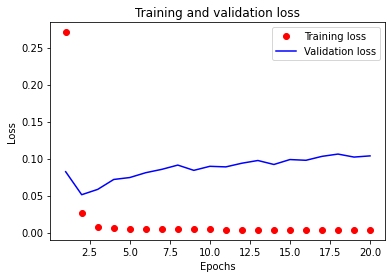

In [25]:
# loss graph
import matplotlib.pyplot as plt

loss = history.history['loss']  # training loss
val_loss = history.history['val_loss']  # validation loss

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

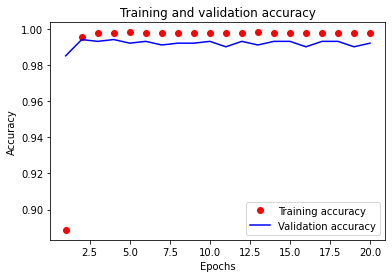

In [26]:
# accuracy graph
plt.clf()  # 그래프 초기화

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
# modeling
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

# compile
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# train
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=8,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Epoch 1/8
45/45 [==============================] - 1s 20ms/step - loss: 0.4224 - accuracy: 0.7978 - val_loss: 0.0887 - val_accuracy: 0.9830
Epoch 2/8
45/45 [==============================] - 1s 14ms/step - loss: 0.0350 - accuracy: 0.9941 - val_loss: 0.0545 - val_accuracy: 0.9900
Epoch 3/8
45/45 [==============================] - 1s 13ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.0719 - val_accuracy: 0.9910
Epoch 4/8
45/45 [==============================] - 1s 14ms/step - loss: 0.0065 - accuracy: 0.9976 - val_loss: 0.0655 - val_accuracy: 0.9890
Epoch 5/8
45/45 [==============================] - 1s 16ms/step - loss: 0.0050 - accuracy: 0.9976 - val_loss: 0.0798 - val_accuracy: 0.9930
Epoch 6/8
45/45 [==============================] - 1s 14ms/step - loss: 0.0055 - accuracy: 0.9977 - val_loss: 0.0870 - val_accuracy: 0.9910
Epoch 7/8
45/45 [==============================] - 1s 14ms/step - loss: 0.0048 - accuracy: 0.9980 - val_loss: 0.0822 - val_accuracy: 0.9900
Epoch 8/8
45/45 [===

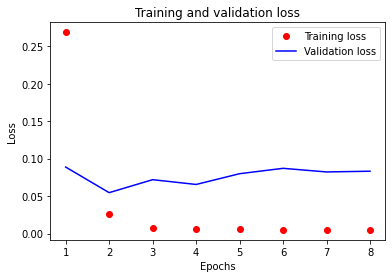

In [28]:
# loss graph
import matplotlib.pyplot as plt

loss = history.history['loss']  # training loss
val_loss = history.history['val_loss']  # validation loss

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

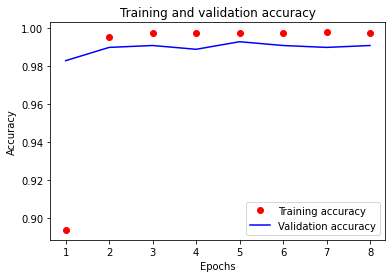

In [29]:
# accuracy graph
plt.clf()  # 그래프 초기화

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# test evaluate

In [34]:
results = model.evaluate(one_hot_test_x, one_hot_test_y)

188/188 [==============================] - 0s 1ms/step - loss: 0.0177 - accuracy: 0.9963


In [35]:
results

[0.01765509881079197, 0.9963284134864807]

In [33]:
import numpy as np

prediction = model.predict(one_hot_test_x)

print('predict : [', end='')
for p in prediction[:5]:
    print(np.argmax(p), end=' ')
#     print(p, end=' ')
print(']')

print('answer : [', end='')
for y in one_hot_test_y[:5]:
    print(np.argmax(y), end=' ')
print(']')

predict : [1 0 0 0 1 ]
answer : [1 0 0 0 1 ]


In [36]:
# modeling
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

# compile
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# train
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=2,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Epoch 1/2
45/45 [==============================] - 1s 18ms/step - loss: 0.4103 - accuracy: 0.8120 - val_loss: 0.0816 - val_accuracy: 0.9890
Epoch 2/2
45/45 [==============================] - 1s 14ms/step - loss: 0.0340 - accuracy: 0.9953 - val_loss: 0.0591 - val_accuracy: 0.9880


In [37]:
results = model.evaluate(one_hot_test_x, one_hot_test_y)

188/188 [==============================] - 0s 1ms/step - loss: 0.0190 - accuracy: 0.9962


In [38]:
results

[0.019035158678889275, 0.9961615204811096]